# NLP Disaster Tweets

In [67]:
#installing scikeras for later use
pip install scikeras

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [93]:
import numpy as np
import pandas as pd 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

#NLP 
import nltk
nltk.download('omw-1.4')
import nltk.corpus
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from keras.preprocessing.text import Tokenizer


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Problem Description and Data Structure

The goal of this project is to accurately categorize tweets into tweets which are about a real disaster or not. The data itself contains 4 factors: the tweet id, the text of the tweet, the keyword of the tweet (may be blank), and the location the tweet was sent from. In order to accomplish this, we will implement a few recurrent neural networks using both LSTM and GRU. One of the LSTM models will be tuned using GridSearch to find optimal hyperparameters for the model with the hopes of creating a better model. Since this project involves text data, we will be using Keras Tokenizer to vectorize the text data for computation.

In [94]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [100]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [106]:
df_train.shape, df_test.shape

((7613, 5), (3263, 4))

In [102]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [105]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


The training data is composed of 7613 tweets while the test data is composed of 3263 tweets. All the factors are string datatypes except for id and target which are integers ranging between 1 and 10873 for id, and 0 and 1 for target.

## Exploratory Data Analysis

In [107]:
#Check for duplicate ids
print(df_train['id'].nunique(), df_train.shape[0])

7613 7613


<AxesSubplot:xlabel='target', ylabel='count'>

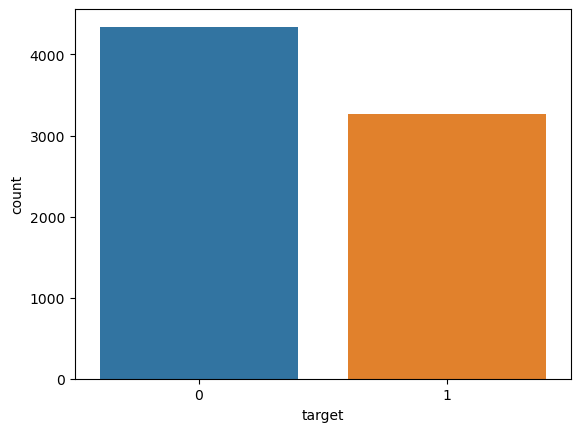

In [108]:
#Plot number of true and false targets
sns.countplot(data = df_train, x = 'target')

The data is relatively evenly split between true and false targets so we will not split the data for an exactly even distribution.

In [109]:
df_train.query('target == 1').location.value_counts()

USA                           67
United States                 27
Nigeria                       22
India                         20
Mumbai                        19
                              ..
Brisbane.                      1
Northern Ireland               1
Broomfield, CO                 1
KÌ¦ln, Nordrhein-Westfalen     1
Manhattan, NY                  1
Name: location, Length: 1513, dtype: int64

In [110]:
df_train.query('target == 0').location.value_counts()

New York                55
USA                     37
London                  29
United States           23
Los Angeles, CA         18
                        ..
Chicago,Illinois         1
Philadelphia, PA         1
NYC area                 1
Durban, South Africa     1
Lincoln                  1
Name: location, Length: 2142, dtype: int64

The location data appears to be primarily from the US. However, most of the location data is completely non-standard. Since location should, in theory, not have a huge bearing on the result of a tweet we will simply drop the location data.

Based on our EDA, the next step is the pre-process the text data so that it can be submitted into a series of neural networks.

## Preprocessing

Here we will implement a number of pre-processing steps for the text data before feeding it into the neural networks. First, since keywords include relevant data for the models we will combine the keywords and text factors while imputing a blank character for any missing value in the keywords feature.

In [74]:
df_train.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

Since the keywords contain possibly useful information about classifying the tweet, we will combine them with the text of the tweet.

In [75]:
#fill null values
df_train.keyword = df_train.keyword.fillna('')
#combine
df_train.text = df_train.text + " " + df_train.keyword


Here we will implement a lemmatizer using NLTKs lemmatizer and tokenizer to reduce the feature space of our data. Tokenizers take text and break it into a series of 'tokens' which are then fed into a lemmatizer which uses an algorithmic approach to reduce words to their base state allowing our model to note similarity between words such as 'cry' and 'crying'.

We will also implement basic word cleaning to remove stopwords, as defined by nltk, as well as punctuation and numbers before lemmatizing.

In [76]:
#implement lemmatizer
def lemmer(text):
    temp = word_tokenize(text)
    lem = WordNetLemmatizer()
    res = ' '.join([lem.lemmatize(x) for x in temp])
    return res

#write a function to clean and prep the text data
def prep(df, col):
    #remove stopwords
    stopword = stopwords.words('english')
    ph = r'\b(?:{})\b'.format('|'.join(stopword))
    df[col] = df[col].str.replace(ph, '')
    
    #remove punctuation
    df[col] = df[col].str.replace('[^\w\s]','')
    
    #remove numbers
    df[col] = df[col].str.replace('\d+', '')
    
    #lemmatize
    df[col] = df[col].apply(lambda string: lemmer(string))
    return

In [77]:
#run functions, drop unneeded columns
prep(df_train, 'text')
df_train.drop(columns = ['keyword', 'location'], axis = 1, inplace = True)

Here we will use Keras Tokenizer function. This function can do a number of things. The first thing it does with fit_on_texts is create a dictionary of each present word sorted by frequency of appearance upto whatever number of words you input (you can limit it to the 10 most frequent etc. however we chose to limit it to the first 1000 for this project even though there are not 1000 unique words post lemmatization). The second thing it does is in texts_to_sequence which just takes the input text and assigns each word its index in the dictionary it created during fit_on_texts. In doing this, we vectorize our text data to run in the model.

In [78]:
#Vectorize text data using Tokenizer
tokenx = Tokenizer(num_words = 1000, split = ' ')
tokenx.fit_on_texts(df_train.text)
df_train_token = pad_sequences(tokenx.texts_to_sequences(df_train.text))

df_train_token.shape

(7613, 23)

In [79]:
#Split data into training and validation 80/20

X_train, X_val, y_train, y_val = train_test_split(df_train_token, df_train.target, test_size = 0.20, random_state = 1)

## Modeling

Here we will implement 3 models. The first model will be a relatively basic LSTM model with dropout layers for regularization. The second model will again be a LSTM model but will use GridSearch to tune the hyperparameters of batch size and learning rate. The third and final model will be a basic GRU model. All three of these models are reasonable models for this project because recurrent neural networks are very good at dealing with text data, similar to how CNNs are good at dealing with image data.

### LSTM model

In [126]:
#create our lstm model
lstm = Sequential()
lstm.add(Embedding(input_dim = 10000, output_dim = 64, input_length = X_train.shape[1]))
lstm.add(LSTM(256, return_sequences = True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(128, return_sequences = True))
lstm.add(Dropout(0.3))
lstm.add(LSTM(64, return_sequences = False))
lstm.add(Dropout(0.3))
lstm.add(Dense(1, activation = 'sigmoid'))

lstm.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
lstm.summary()
         

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 23, 64)            640000    
                                                                 
 lstm_63 (LSTM)              (None, 23, 256)           328704    
                                                                 
 dropout_66 (Dropout)        (None, 23, 256)           0         
                                                                 
 lstm_64 (LSTM)              (None, 23, 128)           197120    
                                                                 
 dropout_67 (Dropout)        (None, 23, 128)           0         
                                                                 
 lstm_65 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_68 (Dropout)        (None, 64)              

In [127]:
#fit to data
lstm_mod = lstm.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10
191/191 [==============================] - 8s 20ms/step - loss: 0.5610 - accuracy: 0.7094 - val_loss: 0.4477 - val_accuracy: 0.7991
Epoch 2/10
191/191 [==============================] - 2s 13ms/step - loss: 0.4278 - accuracy: 0.8125 - val_loss: 0.4412 - val_accuracy: 0.7932
Epoch 3/10
191/191 [==============================] - 2s 13ms/step - loss: 0.4029 - accuracy: 0.8269 - val_loss: 0.4461 - val_accuracy: 0.7919
Epoch 4/10
191/191 [==============================] - 3s 14ms/step - loss: 0.3933 - accuracy: 0.8255 - val_loss: 0.4534 - val_accuracy: 0.7925
Epoch 5/10
191/191 [==============================] - 3s 15ms/step - loss: 0.3842 - accuracy: 0.8368 - val_loss: 0.4550 - val_accuracy: 0.7919
Epoch 6/10
191/191 [==============================] - 2s 13ms/step - loss: 0.3782 - accuracy: 0.8383 - val_loss: 0.4906 - val_accuracy: 0.7840
Epoch 7/10
191/191 [==============================] - 3s 16ms/step - loss: 0.3647 - accuracy: 0.8445 - val_loss: 0.4710 - val_accuracy: 0.7919

### LSTM Model tuning using Keras Classifier and GridSearch

In [82]:
#define function which creates lstm models for Keras Classifier

def create_lstm():
    model = Sequential()
    model.add(Embedding(input_dim = 10000, output_dim = 64, input_length = X_train.shape[1]))
    model.add(LSTM(256, return_sequences = True))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences = True))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences = False))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model
    

In [83]:
#set up param grid
batch_size = [16, 32]
learning_rate = [0.01, 0.1]
p_grid = dict(batch_size = batch_size, optimizer__learning_rate = learning_rate)

#initialize KerasClassifer
mod = KerasClassifier(model = create_lstm, epochs = 5, loss = 'binary_crossentropy', verbose = 0)

In [84]:
#gridsearch
grid = GridSearchCV(estimator = mod, param_grid = p_grid, cv = 3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=KerasClassifier(epochs=5, loss='binary_crossentropy', model=<function create_lstm at 0x7fc367aa17a0>, verbose=0),
             param_grid={'batch_size': [16, 32],
                         'optimizer__learning_rate': [0.01, 0.1]})

In [85]:
#Return best params and best model
print('Best accuracy was %f using: %s' % (grid.best_score_, grid.best_params_))
lstm_tuned = grid.best_estimator_

Best accuracy was 0.765353 using: {'batch_size': 32, 'optimizer__learning_rate': 0.01}


### Basic GRU Model

In [131]:
#build a basic GRU model
gru = Sequential()
gru.add(Embedding(input_dim = 10000, output_dim = 64, input_length = X_train.shape[1]))
gru.add(GRU(256, return_sequences = True))
gru.add(Dropout(0.3))
gru.add(GRU(128, return_sequences = True))
gru.add(Dropout(0.3))
gru.add(GRU(64, return_sequences = False))
gru.add(Dropout(0.3))
gru.add(Dense(1, activation = 'sigmoid'))

gru.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
gru.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 23, 64)            640000    
                                                                 
 gru_3 (GRU)                 (None, 23, 256)           247296    
                                                                 
 dropout_69 (Dropout)        (None, 23, 256)           0         
                                                                 
 gru_4 (GRU)                 (None, 23, 128)           148224    
                                                                 
 dropout_70 (Dropout)        (None, 23, 128)           0         
                                                                 
 gru_5 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_71 (Dropout)        (None, 64)              

In [132]:
gru_mod = gru.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10
191/191 [==============================] - 8s 17ms/step - loss: 0.5372 - accuracy: 0.7286 - val_loss: 0.4468 - val_accuracy: 0.7899
Epoch 2/10
191/191 [==============================] - 3s 14ms/step - loss: 0.4282 - accuracy: 0.8099 - val_loss: 0.4458 - val_accuracy: 0.7951
Epoch 3/10
191/191 [==============================] - 2s 12ms/step - loss: 0.4052 - accuracy: 0.8207 - val_loss: 0.4476 - val_accuracy: 0.7965
Epoch 4/10
191/191 [==============================] - 2s 12ms/step - loss: 0.3846 - accuracy: 0.8355 - val_loss: 0.4535 - val_accuracy: 0.7859
Epoch 5/10
191/191 [==============================] - 2s 12ms/step - loss: 0.3617 - accuracy: 0.8414 - val_loss: 0.4748 - val_accuracy: 0.7787
Epoch 6/10
191/191 [==============================] - 2s 12ms/step - loss: 0.3392 - accuracy: 0.8601 - val_loss: 0.4867 - val_accuracy: 0.7879
Epoch 7/10
191/191 [==============================] - 2s 12ms/step - loss: 0.3168 - accuracy: 0.8693 - val_loss: 0.5439 - val_accuracy: 0.7814

## Results

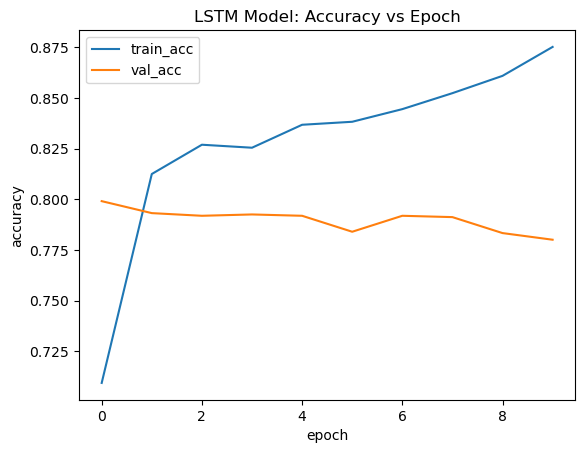

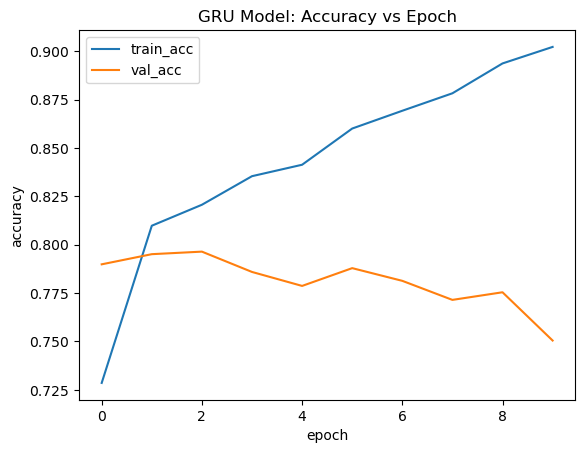

In [133]:
#Visualizations for the LSTM and GRU Model


plt.plot(lstm_mod.history['accuracy'], label = 'train_acc')
plt.plot(lstm_mod.history['val_accuracy'], label = 'val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('LSTM Model: Accuracy vs Epoch')
plt.show()

plt.plot(gru_mod.history['accuracy'], label = 'train_acc')
plt.plot(gru_mod.history['val_accuracy'], label = 'val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('GRU Model: Accuracy vs Epoch')
plt.show()


The GRU model appears to perform very slightly worse than the LSTM model but has slightly faster model fitting time. In order to determine which of the three models is the best we will submit all 3 and take whichever has the highest score.

In [88]:
#Do same preprocessing for test data

df_test.keyword = df_test.keyword.fillna('')
df_test.text = df_test.text + " " + df_test.keyword
prep(df_test, 'text')
df_test.drop(columns = ['keyword', 'location'], axis = 1, inplace = True)

In [89]:
#Vectorize text data using Tokenizer
tokeny = Tokenizer(num_words = 1000, split = ' ')
tokeny.fit_on_texts(df_test.text.values)
df_test_token = pad_sequences(tokenx.texts_to_sequences(df_test.text.values), maxlen = 23)

In [90]:
pred_lstm = lstm_mod.predict(df_test_token)
pred_lstm_tuned = lstm_tuned.predict(df_test_token)
pred_gru = gru_mod.predict(df_test_token)

102/102 [==============================] - 1s 4ms/step


In [91]:
submission_lstm = pd.DataFrame({'id': df_test.id, 'target': list(map(lambda x: 0 if x < 0.5 else 1, pred_lstm))})
submission_gru = pd.DataFrame({'id': df_test.id, 'target': list(map(lambda x: 0 if x < 0.5 else 1, pred_gru))})
submission_tuned = pd.DataFrame({'id': df_test.id, 'target': pred_lstm_tuned})

submission_tuned.to_csv('submission.csv', index = False)

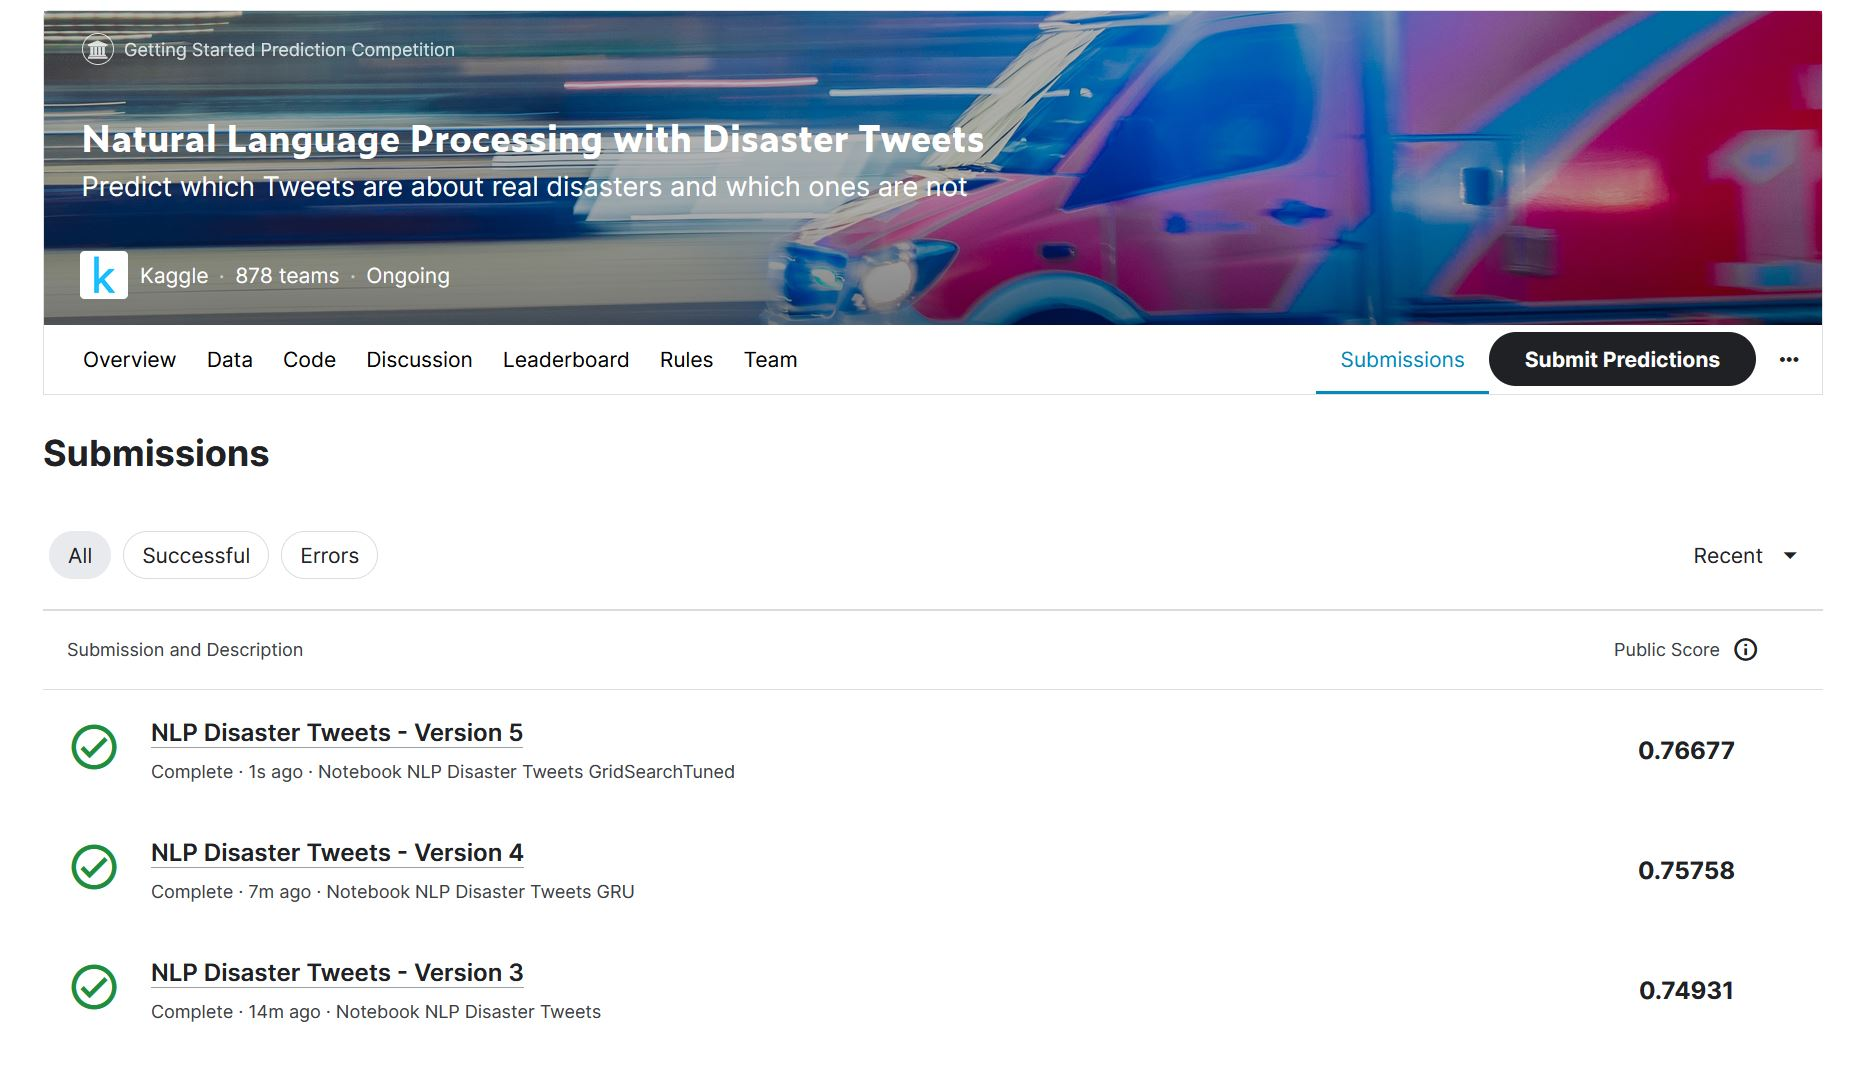

The models from top to bottom are: GridSearch LSTM, GRU, LSTM

As we can see, the model with tuned hyperparameters performed the best, while GRU slightly outperformed LSTM. It makes sense that the model with tuned hyperparameters performed the best because that model calculated its accuracy using 3-fold cross validation to determine the batch size and optimal learning rate for this data. The other two models had no hyperparameter tuning but still performed comparably. 

## Conclusion

From this project, we determined that having a lower learning rate with a medium batch size appeared to produce the best model. We also learned that LSTM, pre-hyperparameter tuning, have extremely similar performances however GRU has the edge in computational efficiency. 

A number of improvements could be made to this project in the future. First, we could try to implement a number of other RNNs such as DistilBERT which may perform better on this data. Secondly, we could do further hyperparameter tuning by changing things such as the optimizer, the number of LSTM/GRU layers, or the number of epochs over which the models run. We could also do more in-depth hyperparameter tuning for the parameters we did tune: batch size, and learning rate, in order to get a better overall understanding of the effects of each on model performance rather than just testing between two outcomes for each. The reason neither was implemented for this project was due to a lack of memory within Kaggle which prevented us from running larger GridSearch operations. Thirdly, we could implement a different vectorizer for our text data such as TfidfVectorizer which may do a better job at prepping text data for our model than the simple tokenizer we used in this project.

## References

We used https://www.nltk.org/ for its tokenizer and lemmatizer.

We used https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer to vectorize the raw text data for modelling use.